In [1]:
from transformers import logging
from transformers import BertModel, BertTokenizer
from transformers import pipeline
import torch
import torch.nn as nn
import numpy as np
from torch.nn.functional import normalize, log_softmax, kl_div

In [2]:
logging.set_verbosity_error()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from TRExData.HardTRExData import HardKnownTRExData
from TRExData.LamaTRExData import LamaTRExData
from SentenceComparison.ScoreProbabilityComparison import ScoreProbabilityComparison 
from ModelHelpers.fill_mask_helpers import get_probability_from_pipeline_for_token
from ModelHelpers.data_helpers import create_known_filter_getter, create_hard_filter_getter
from relation_templates.templates import get_templates, get_relation_meta, relations, relation_names, get_relation_cardinality
from PipelineCacheWrapper.PipelineCacheWrapper import PipelineCacheWrapper

In [4]:
model = "bert-base-cased"
data_source = "hard and known"

In [5]:
measure = "correct token score"
#persister = ResultPersister(model, data_source, measure)

In [6]:
%%time
unmasker = PipelineCacheWrapper('fill-mask', model=model, top_k=10)

CPU times: user 1.75 s, sys: 276 ms, total: 2.02 s
Wall time: 7.3 s


In [7]:
def model_to_tokens(sentence):
    result = unmasker(sentence)
    result = sorted(result, key=lambda entry: entry["score"], reverse=True)
    return [entry["token_str"] for entry in result]

In [8]:
get_hard_filter = create_hard_filter_getter(model_to_tokens, get_templates)
get_known_filter = create_known_filter_getter(model_to_tokens, get_templates, get_relation_cardinality)

In [9]:
MASK = "[MASK]"
OBJ_LABEL = "obj-label"
SUBJ_LABEL = "sub-label"
VOCABULARY_SIZE = 28996
words = [] 
number_of_bins = 100

In [10]:
#relations = ["P140", "P127", "P36", "P159"]
#relations = ["P1303"]
#relations = ["P19", "P413", "P159", "P103"]

In [11]:
TREx = HardKnownTRExData(get_hard_filter, get_known_filter, relations = relations)
TREx.load()
relations = list(TREx.data.keys())

In [12]:
unmasker = PipelineCacheWrapper('fill-mask', model=model, top_k=500)

In [13]:
@torch.no_grad()
def metric(sentence: str, token: str):
    prob = get_probability_from_pipeline_for_token(unmasker(sentence), token)
    return prob

In [14]:
Comparer = ScoreProbabilityComparison(relations, get_templates, metric, MASK, get_relation_meta, number_of_bins)

In [15]:
Comparer.compare(TREx.data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 3569.61it/s]


%%time
unmasker.save_to_cache()

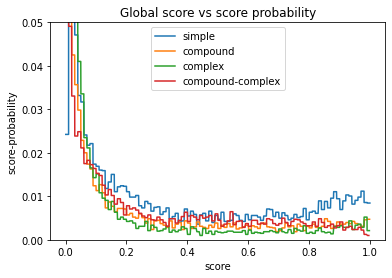

In [16]:
Comparer.plot_global_comparison()

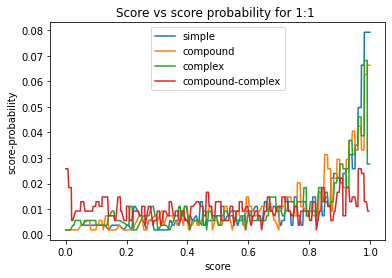

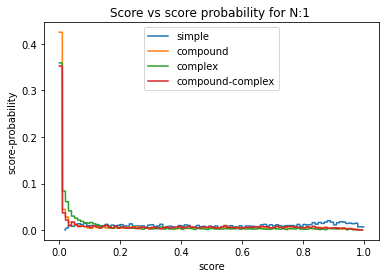

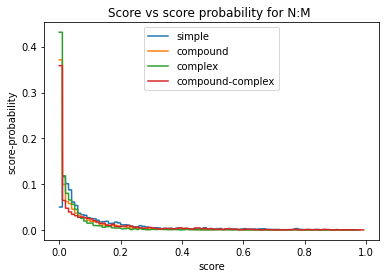

In [17]:
#Comparer.plot_cardinality_comparison([0.0, 0.02])
Comparer.plot_cardinality_comparison()

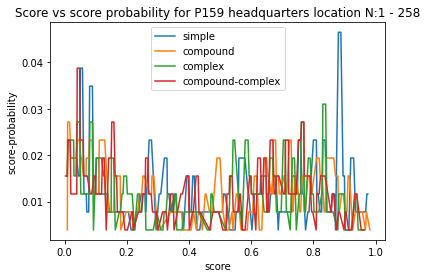

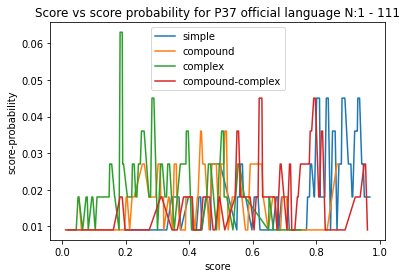

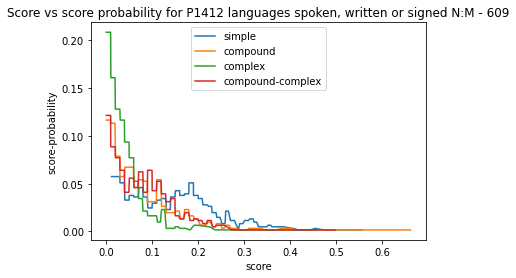

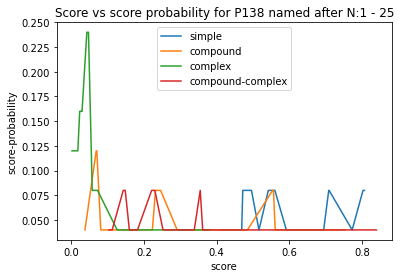

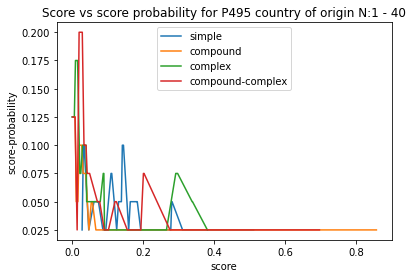

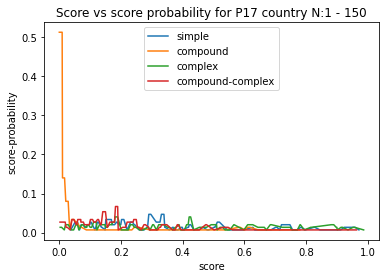

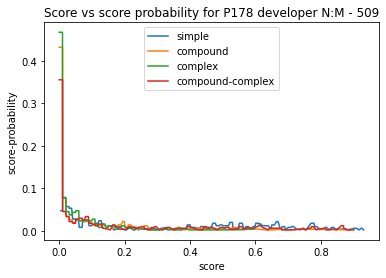

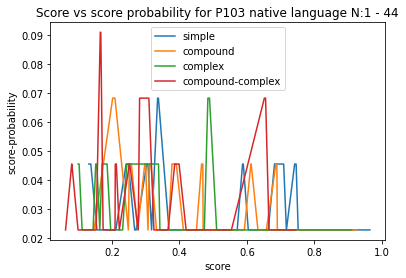

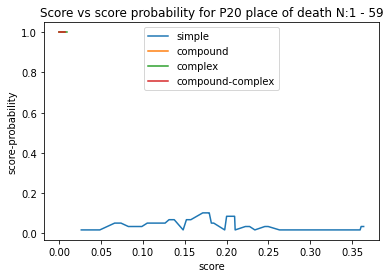

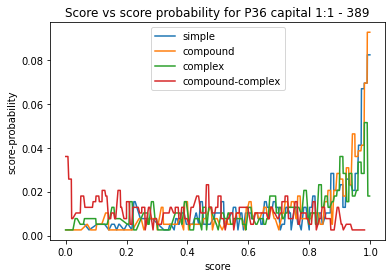

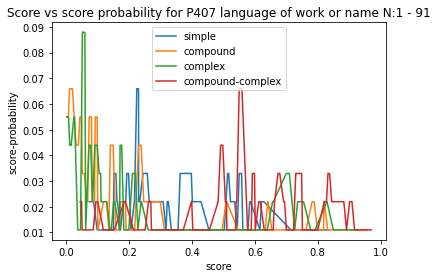

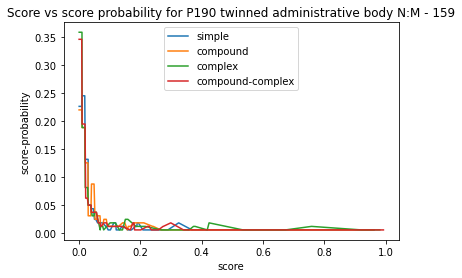

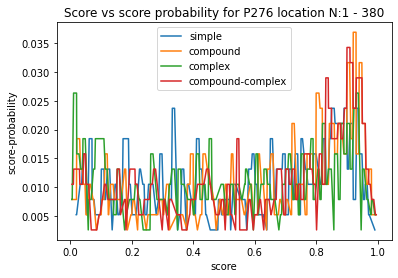

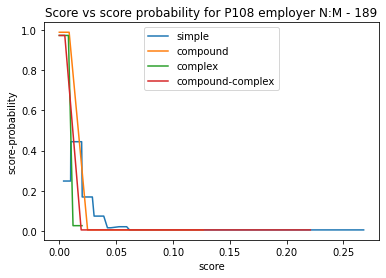

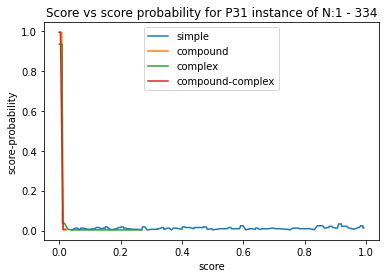

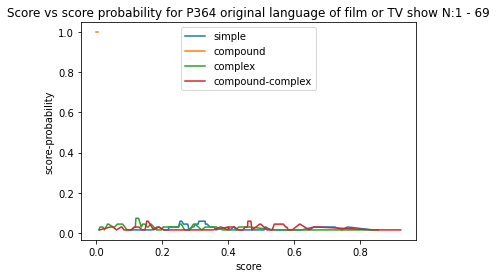

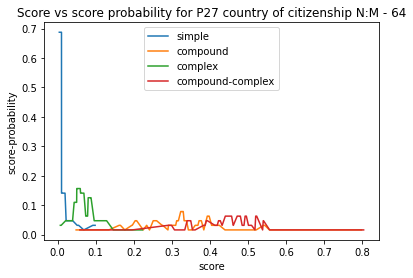

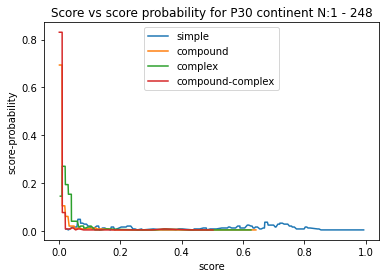

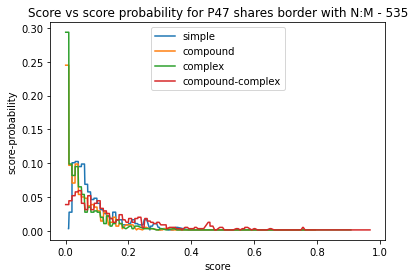

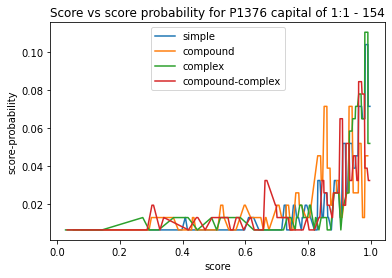

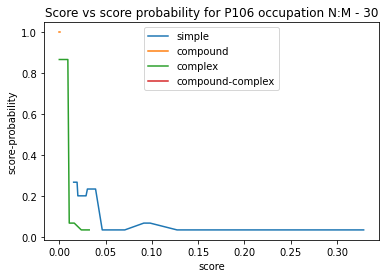

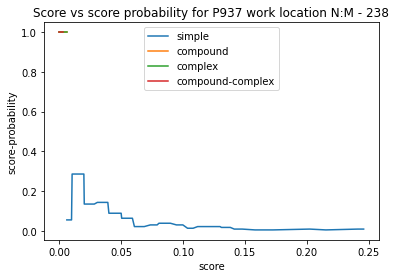

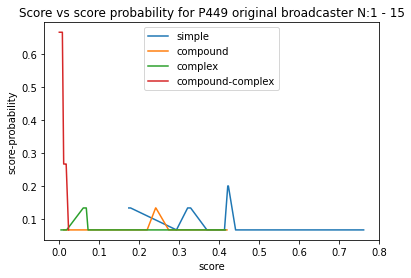

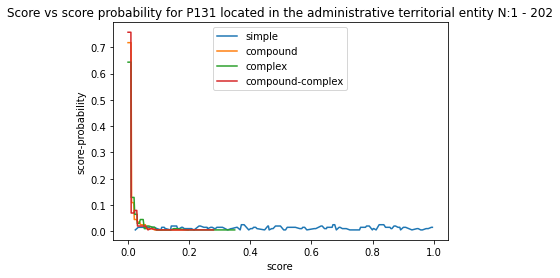

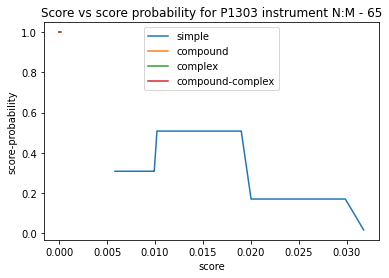

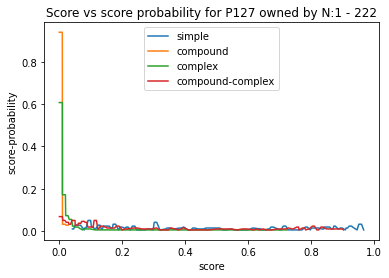

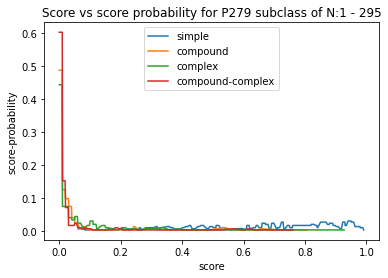

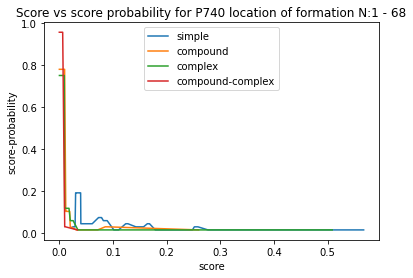

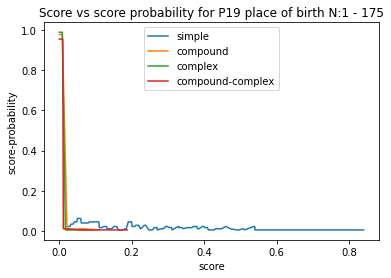

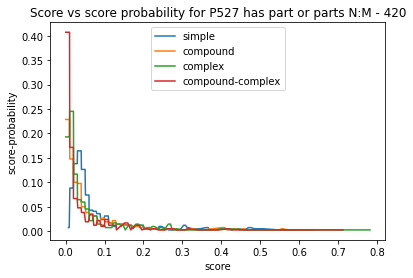

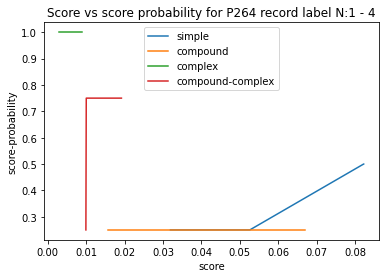

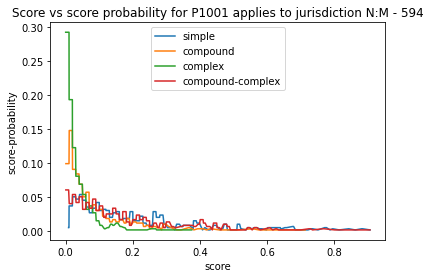

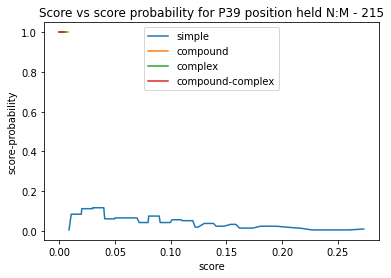

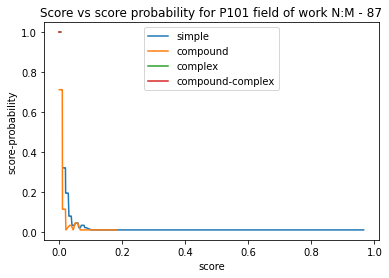

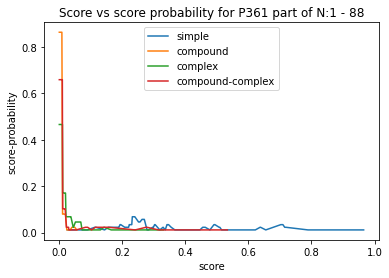

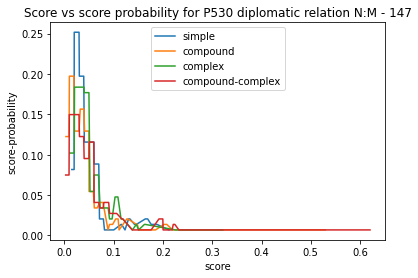

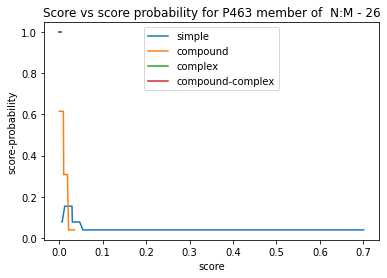

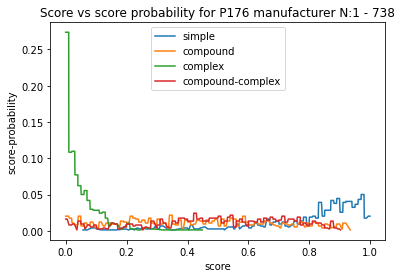

In [18]:
Comparer.plot_relation_comparison()

In [19]:
unmasker.save_to_cache()

In [20]:
import math

def kll_metric(left_dist, right_dist):
    value = 0.0
    for p, q in zip(left_dist, right_dist):
        if p > 0 and q > 0:
            value += p * math.log(p/q)
    return round(value, 3)

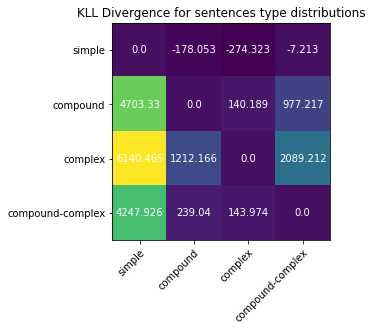

In [21]:
Comparer.plot_heat_map(kll_metric, "KLL Divergence for sentences type distributions")

In [22]:
TREx = LamaTRExData(relations = relations)
TREx.load()
Comparer.compare(TREx.data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 982/982 [00:00<00:00, 5188.60it/s]


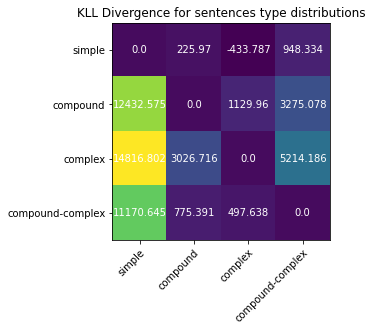

In [23]:
Comparer.plot_heat_map(kll_metric, "KLL Divergence for sentences type distributions")

In [24]:
unmasker.save_to_cache()